# Analyzing results

In [ ]:
import sys,os
root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from lib.utils import utils
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

## Computing Triples

### Get a number of games

In [ ]:
start_index = 0
num_games = 100
path = "../data/diplomacy-v1-27k-msgs/standard_no_press.jsonl"
games_jsons = utils.load_jsonl(path, num_games=num_games, mmap=False, completed_only=True)

In [ ]:
# Convert to a pandas dataframe
df = pd.DataFrame(games_jsons)

In [ ]:
games = df['phases']
games.apply(lambda x: x[0])

In [ ]:
for game in games:
    for ix, iy in enumerate(game):
        game[ix]['phase_id'] = ix

### Flatten json records

In [ ]:
all_records = []
for idx, game in enumerate(games):
    for idx, phase in enumerate(game):
        row_generator = utils.flatten_json(phase)
        assert row_generator is not None, row_generator
        for row in row_generator:
            all_records.append(row.copy())

### Get the complete dataframe with an added column

In [ ]:
complete_df = pd.DataFrame.from_records(all_records)
complete_df['unique_unit_id'] = -1

### Get the unique games in the dataframe

In [ ]:
unique_games = complete_df["game_id"].unique()

### Do temporal binding of units

In [ ]:
game_phase_df_list = []
for idx, game_id in enumerate(unique_games):
    phases_df_list = []
    print(idx, game_id, flush=True)
    s_dict = {}
    d_dict = {}
    _id = 1
    game_df = complete_df.loc[complete_df["game_id"].apply(lambda x: x == game_id)]
    unique_phases = game_df['phase_id'].unique()
    for phase in unique_phases:
        condition = game_df["phase_id"].apply(lambda x: x == phase)
        phase_df = game_df.loc[condition]
        s_dict, d_dict, _id = utils.assign_unit_id(phase_df, s_dict, d_dict, _id, discard_disband_creation=False)
        phases_df_list.append(phase_df)
    phases_cdf = pd.concat(phases_df_list)
    dislodged_df = phases_cdf.loc[phases_cdf['action'] == -2].copy()
    utils.replace_dislodged_units(phases_cdf, dislodged_df)
    game_phase_df_list.append(phases_cdf)


In [ ]:
cdf = pd.concat(game_phase_df_list)

### Assert no invalid rows are left

In [ ]:
assert cdf.loc[cdf['coordinator'] == 'RA'].empty

In [ ]:
cdf.loc[cdf['unique_unit_id'].apply(lambda x: x == 1)].head()

### Filter out adjustment and retreat seasons

In [ ]:
spring_fall_phases=(cdf['phase_name'].apply(lambda x:x[0])!='W') & (cdf['phase_name'].apply(lambda x:x[-1])!='R') & (cdf['phase_name'].apply(lambda x:x[-1]) == 'M')
cdf_sf = cdf.loc[spring_fall_phases].copy()
cdf_sf['phase_num']=cdf_sf.phase_name.apply(lambda x: float(x[1:-1]+('.0' if x[0]=='S' else '.5')))

In [ ]:
cdf_sf.head()

### Get the triples' presence based on the filtered dataframe

In [ ]:
game_triple_presence = {}
for idx, game_id in enumerate(unique_games):
    assert type(game_id) is str, (game_id, "is not a string")
    print(idx, game_id)
    game_df = cdf_sf.loc[cdf_sf['game_id'] == game_id]
    
    if game_df.unique_unit_id.nunique() == game_df.unique_unit_id.max():
        triples = utils.get_triples(game_df)
        try:
            emp = utils.get_triples_presence(game_df, triples)
            print(emp, len(triples))
            game_triple_presence[game_id] = triples
        except AssertionError as msg:
            print(msg)
    if idx == 0:
        break

### Save json file if necessary

In [ ]:
    name = "whatever"
    with open(f'{name}.json', 'w') as file:          
        json.dump(game_tiple_presence, file, indent=4, sort_keys=True,)

In [ ]:
cdf_sf[cdf_sf["unique_unit_id"].apply(lambda x: x == 1)].head(20)

## Analyze the gathered triples

In [ ]:
path = ""
with open(f'{path}', 'r') as file:
    game_triple_presence = json.load(file)

In [ ]:
list(game_triple_presence.values())[0][0]

In [ ]:
game_id = list(game_triple_presence.keys())[0]

In [ ]:
all_records = []
for row in utils.gen_triple_rows(game_triple_presence):
    all_records.append(row.copy())

In [ ]:
df = pd.DataFrame.from_records(all_records)

In [ ]:
df = df.dropna()

In [ ]:
df.reset_index(inplace=True)

In [177]:
df.head()

,index,game_id,player_i,player_j,min_phase_num,max_phase_num,triple_0,triple_1,triple_2,factor_same,factor_diff
0,0,rW_Q9TpidGLGD2EL,ENGLAND,RUSSIA,1901.0,1902.5,4,5,16,1.5,1.5
1,1,rW_Q9TpidGLGD2EL,ENGLAND,RUSSIA,1901.0,1902.5,4,5,17,1.5,1.5
2,2,rW_Q9TpidGLGD2EL,ENGLAND,RUSSIA,1901.0,1902.5,4,5,18,1.5,1.0
3,3,rW_Q9TpidGLGD2EL,ENGLAND,RUSSIA,1901.0,1902.5,4,5,19,1.5,1.0
4,4,rW_Q9TpidGLGD2EL,ENGLAND,RUSSIA,1902.0,1902.5,4,5,31,2.0,2.0


### Your Method

In [178]:
#collect into a loop
same_pair_inds=[0,1]
diff_pair_inds=[0,2]
# for game_id,di in jj.items():
jj = game_triple_presence
samediff_count_list=[]
di=jj[game_id]
game_df=cdf_sf[(cdf_sf.game_id==game_id)]
for triple_id,triple in enumerate(di):
    if triple['max_min_diff']>0:
        seq=game_df[(game_df.coordinator.isin([triple['player_i'],triple['player_j']])) 
            & (game_df.unique_unit_id.isin(triple['triple'])) 
            & (game_df.phase_num.isin(np.arange(triple['min_phase_num'],triple['max_phase_num'],0.5)))].loc[:,('coordinator','unique_unit_id','phase_num','action')]

        datatmp=seq.groupby(['unique_unit_id','phase_num'])['action'].aggregate('first').unstack()
        unit_counts=datatmp.nunique(axis=1)
        tridat=np.asarray(triple['triple'])
        joint_counts=[len(datatmp.loc[np.asarray(triple['triple'])[same_pair_inds]].T.drop_duplicates()), \
                      len(datatmp.loc[np.asarray(triple['triple'])[diff_pair_inds]].T.drop_duplicates())]
        factor_same=np.prod(unit_counts[tridat[same_pair_inds]].values)/joint_counts[0]
        factor_different=np.prod(unit_counts.loc[tridat[diff_pair_inds]].values)/joint_counts[1]
        samediff_count_list.append((factor_same,factor_different))
    else:
        samediff_count_list.append(None)

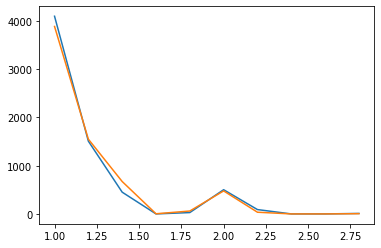

In [179]:
fig,ax=plt.subplots()
for data in zip(*filter(None,samediff_count_list)):
    counts,bins=np.histogram(data)
    ax.plot(bins[:-1],counts)

### VS Mine

In [180]:
samediff_count_list_2 = (df.factor_same.values, df.factor_diff.values)

In [181]:
a = zip(samediff_count_list_2[0],samediff_count_list_2[1])

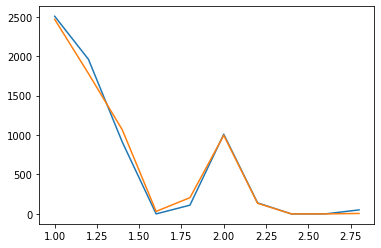

In [182]:
fig,ax=plt.subplots()
for data in zip(*filter(None,a)):
    counts,bins=np.histogram(data)
    ax.plot(bins[:-1],counts)